In [105]:
from pylab import *
from scipy import fft
import matplotlib.pyplot as plt
from scipy.signal import periodogram as psd
import numpy as np
from scipy.signal import find_peaks
from math import sqrt, sin
from cmath import pi
from numba import njit
from scipy.integrate import quad

%matplotlib inline

In [126]:
#This code, as borrowed from the Power Law Relationship file calcualtes the power (W)  of blackbody spectrum for a given frequncy 
#fixed variables
k_B = 8.617333262145e-5 #eV K^{-1}
h = 4.135667696e-15 #eV * s
c = 299792458 #m / s
eV_to_J = 1.602176565e-19 
Temp = 2000 #K

#modifiable variables
r_rad_small = 0.001 #m -radius of radiator
r_abs = 0.001 #m -radius of absorber
d =  0.1 #m -distance between absorber and radiator ?

#a is lower lim, b is upper lim, n is number of slices
#@njit
def simpson(g, a, b, n): 
    h=(b-a)/n
    k=0.0
    x=a + h
    for i in arange(1,n/2 + 1):
        k += 4*g(x)
        x += 2*h
    x = a + 2*h
    for i in arange(1,n/2):
        k += 2*g(x)
        x += 2*h
    r = (h/3)*(g(a)+g(b)+k)
    return r

def gamma_0(T, r_rad):  
    area = pi * r_abs**2
    sin_theta = r_rad /np.sqrt(r_rad**2 + d**2)
    return area*sin_theta * (8 * pi * (k_B * T)**2)/(h**3 * c**2)

#function to integrate via Sumpson's rule
#Noah's modifications to be overflow safe
def power_integral(x):
    #if we have a list, convert to numpy array
    if(type(x)==list):
        x = np.array(dtype=np.float128)
        
    #if we have a numpy array, proceed
    if(type(x)== np.ndarray):
        retvals = np.zeros_like(x,dtype=np.float128)
        inds = x < 1e3
        #small values can be directly calculated
        retvals[inds] = x[inds]**3/(np.exp(x[inds])-1.0)
        #in the limit of large x, f(x)~exp(-x)
        retvals[~inds] = np.exp(-x[~inds])
        return retvals
    
    #assume we have a number
    else: 
        if(type(x)!='float128'):
            x=np.float128(x)
        if(x>1e3):
            return np.exp(-x)
        else:
            return x**3/(np.exp(x)-1.0)

#this function returns power, given bounds in terms of energy
def power_func(T, a, b, r_rad):
    start = a/(k_B * T)  #lowerbound
    end = b/(k_B * T) #upperbound
    n = 100 #slices
    return eV_to_J * k_B**2 * T**2 * gamma_0(T, r_rad)*simpson(power_integral,start,end,n)

def power_func_trap(T, a, b, r_rad):
    start = a/(k_B * T)  #lowerbound
    end = b/(k_B * T) #upperbound
    return eV_to_J * k_B**2 * T**2 * gamma_0(T, r_rad)*simpson(power_integral,start,end,2)

def power_intensity(v, slice_size, Temp=2e3):
    E_min = (v-slice_size/2.0)*h #eV 
    E_max = (v+slice_size/2.0)*h #eV 
    #print("e = " , v*h, " & E_min =", E_min," & E_max =", E_max )
    power = power_func(Temp, E_min, E_max, r_rad_small)
    return power

def power_intensity_trap(v, slice_size, Temp=2e3):
    E_min = (v-slice_size/2.0)*h #eV 
    E_max = (v+slice_size/2.0)*h #eV 
    #print("e = " , v*h, " & E_min =", E_min," & E_max =", E_max )
    power = power_func_trap(Temp, E_min, E_max, r_rad_small)
    return power

def blackbodyWeights(freqs,slice_size, Temp=2e3, useTrap=False):
    if(useTrap):
        return np.fromfunction(lambda i : power_intensity_trap(freqs[i],slice_size, Temp=Temp),freqs.shape, dtype=int)
    else:
        return np.fromfunction(lambda i : power_intensity(freqs[i],slice_size, Temp=Temp),freqs.shape, dtype=int)

In [127]:
def makePlotTiming(slice_size,useTrap=False):
    freqs = np.arange(slice_size,1e15,slice_size)
    blackbodyWeights(freqs,slice_size,useTrap=useTrap)*(1e10/slice_size)
    
for slice_size in [1e9,1e10,1e11]:
    %timeit makePlotTiming(slice_size)

3.18 s ± 60.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
307 ms ± 2.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
31.6 ms ± 413 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [128]:
def makePlotTiming(slice_size,useTrap=False):
    freqs = np.arange(slice_size,1e15,slice_size)
    blackbodyWeights(freqs,slice_size,useTrap=useTrap)*(1e10/slice_size)
    
for slice_size in [1e9,1e10,1e11]:
    %timeit makePlotTiming(slice_size,useTrap=True)

117 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
11.1 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.1 ms ± 11.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


0.029909988698900644
0.029909988698900644
0.029909988698900644


/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


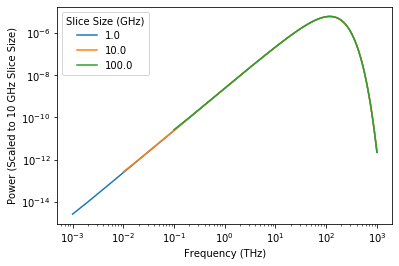

0.029909988698900644
0.029909988698900644


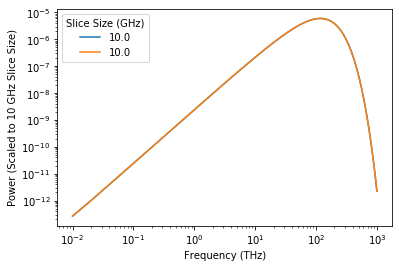

In [129]:
def makePlot(slice_size,useTrap=False):
    freqs = np.arange(slice_size,1e15,slice_size)
    w = blackbodyWeights(freqs,slice_size,useTrap=useTrap)
    plot(freqs*1e-12,w*(1e10/slice_size),label=slice_size*1e-9)
    print(np.sum(retvals))
    yscale('log')
    xscale('log')
    
for slice_size in [1e9,1e10,1e11]:
    makePlot(slice_size)
legend(title='Slice Size (GHz)')
xlabel('Frequency (THz)')
ylabel('Power (Scaled to 10 GHz Slice Size)')
show()

slice_size=1e10
for useTrap in [True,False]:
    makePlot(slice_size,useTrap=useTrap)
legend(title='Slice Size (GHz)')
xlabel('Frequency (THz)')
ylabel('Power (Scaled to 10 GHz Slice Size)')
show()

/anaconda3/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


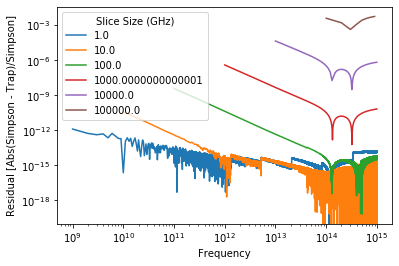

In [140]:
slice_size=1e9
for slice_size in [1e9,1e10,1e11,1e12,1e13,1e14]:
    freqs = np.arange(slice_size,1e15,slice_size)
    w = blackbodyWeights(freqs,slice_size,useTrap=False)
    wT = blackbodyWeights(freqs,slice_size,useTrap=True)
    plot(freqs,abs((w-wT)/w),label=slice_size*1e-9)
legend(title='Slice Size (GHz)')
ylabel('Residual [Abs(Simpson - Trap)/Simpson]')
xlabel('Frequency')
yscale('log')
xscale('log')

In [44]:
from timeit import timeit

slice_size=1e10
freqs = np.arange(1e12,1e14,slice_size)

def testFunc1():
    retvals = np.zeros_like(freqs)
    for i in range(0,len(freqs)):
        retvals[i] = power_intensity(freqs[i],slice_size)
    return retvals

def testFunc2():
    return np.fromfunction(lambda i : power_intensity(freqs[i],slice_size),freqs.shape, dtype=int)

%timeit testFunc2()

30.1 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [45]:
%timeit testFunc1()

4.1 s ± 39.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:62: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:80: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

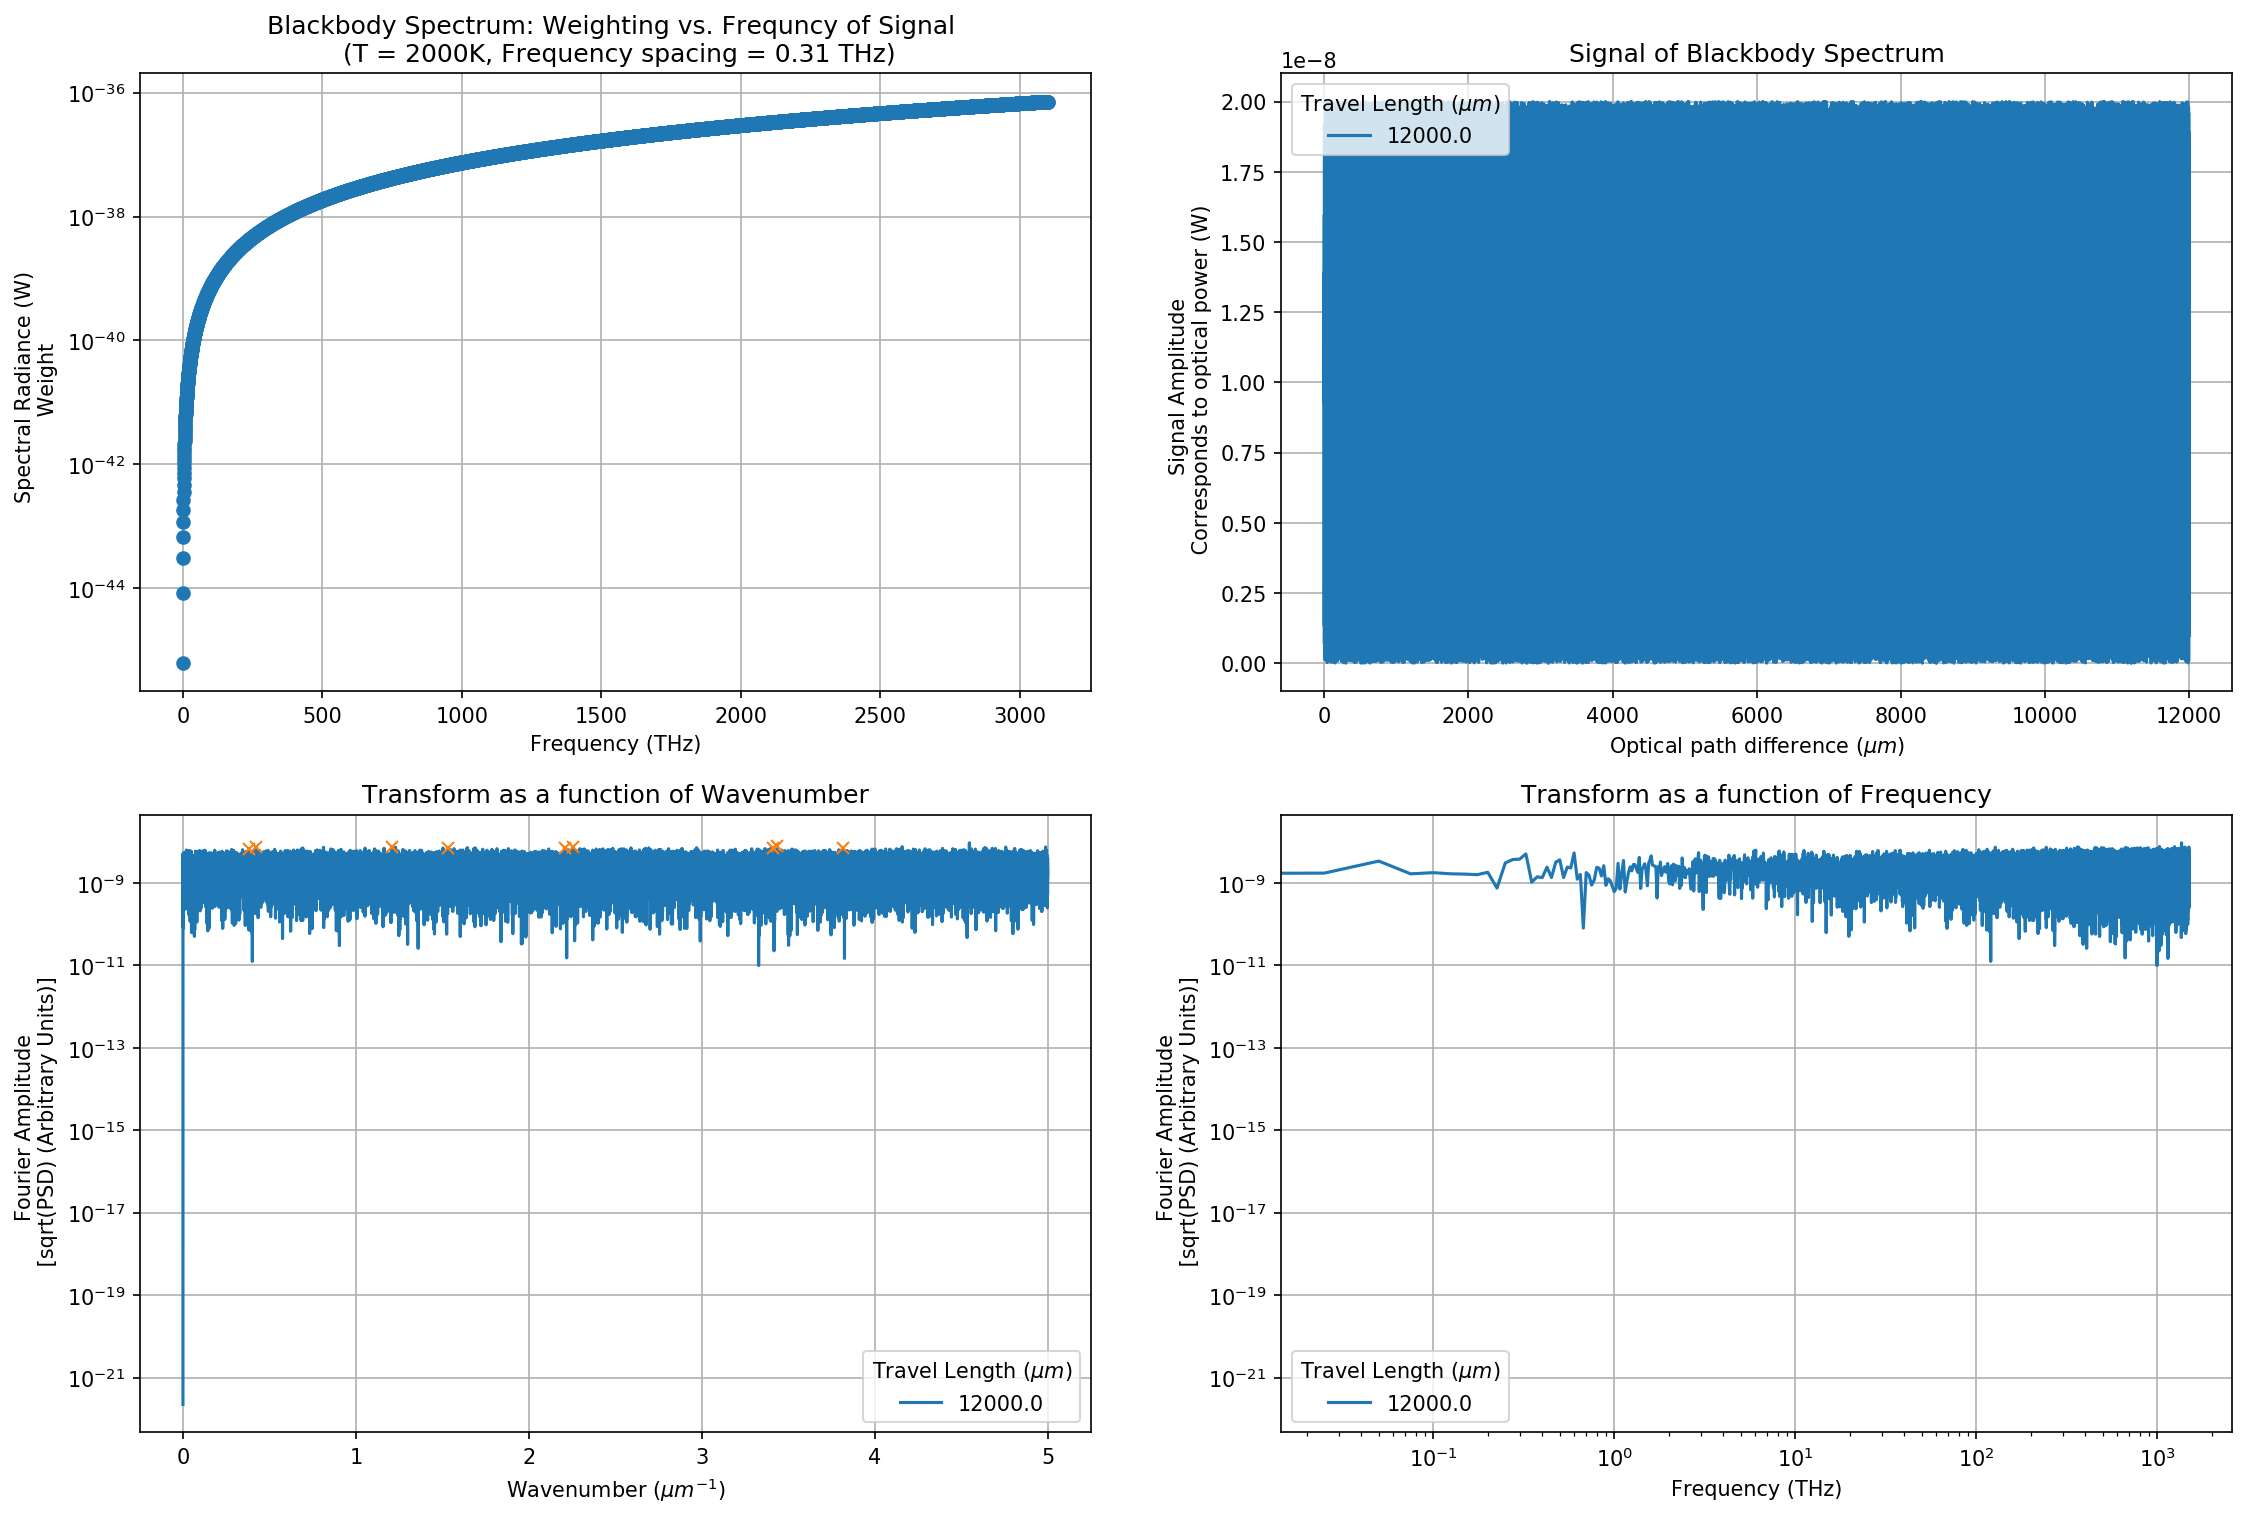

In [5]:
arm_length_1 = 15 #cm
arm_length_2 = 10 #cm
cm_to_micron = 10000
dx = abs(arm_length_1-arm_length_2)*cm_to_micron

adjustment = 1e-7

dt = 0.1 #micron, step size
fs = 1/dt #micron^-1, inv. step size (multiply by h gives energy resolution)
T = 12e3 #micron, total travel length
sigma = 2e-8 #noise offset intensity
peaks = []
weights_nofilter = []
c_micron_per_second = 3e8 * 1e6
Hz_to_THz = 1e-12
peak_thershold = 1e-6 #increase this as noise increases, to ensure we are not accidnetally claiming the noise as a peak

fig = plt.figure(figsize=(18, 12), dpi=150)  

#for blackbody spectrum, decide frequeny range and number of frequency slices 
min_frequency = 0.01 #THz
max_frequency = 3100 #THz
num_slices = 10000 #1e6
frequency_slice_size = (max_frequency - min_frequency)/num_slices #micron
frequencies = arange(min_frequency, max_frequency, frequency_slice_size)


#This section of code creates the signal
for nu in frequencies: #(THz)
  weights_nofilter.append(power_intensity(nu, frequency_slice_size)) # for blackbody, this is the blackbody intensity in W
plt.subplot(2, 2, 1)
plt.plot(frequencies, weights_nofilter , 'o')

x=np.arange(0,T,dt)
y_phaseNoise = np.zeros_like(x)
for nu in range(len(frequencies)):
  k = frequencies[nu]/(Hz_to_THz*c_micron_per_second) #get wavenumber
  phase = 2*pi*dx*k #phase offset depends on wavenumber
  y_phaseNoise += weights_nofilter[nu]*1/2*(np.cos(2*pi*k*x + phase)+ 1)
y = y_phaseNoise + np.random.rand(len(x))*sigma #create the input signal


plt.subplot(2, 2, 2)
plt.plot(x,y,label= T)

plt.subplot(2, 2, 3)
f_nofilter,p_nofilter = psd(y,fs=fs) #wavenumber, spectrum
plt.semilogy(f_nofilter, np.sqrt(p_nofilter), label=T)
peaks_index, _ = find_peaks(np.log10(np.sqrt(p_nofilter)), prominence=(2.3))
plt.plot(f_nofilter[peaks_index], np.sqrt(p_nofilter[peaks_index]), "x")
peaks.append(f_nofilter[peaks_index])

p_adjusted_nofilter = np.sqrt(p_nofilter) - adjustment
for ps in range(len(p_adjusted_nofilter)):
  if p_adjusted_nofilter[ps] < 0:
    p_adjusted_nofilter[ps] = 0

plt.subplot(2, 2, 4)
plt.semilogy(f_nofilter*c_micron_per_second*Hz_to_THz, np.sqrt(p_nofilter),label=T)

#plot details for blackbody spectrum plot
plt.subplot(2, 2, 1)
plt.grid(True)
plt.yscale('log')
title = "Blackbody Spectrum: Weighting vs. Frequncy of Signal \n (T = " + str(Temp) + "K, Frequency spacing = "+ str(round(frequency_slice_size,2)) + " THz)"
plt.title(title)
plt.xlabel("Frequency (THz)")
plt.ylabel("Spectral Radiance (W) \n Weight")

#plot details for signal plot
plt.subplot(2, 2, 2)
plt.grid(True)
plt.title("Signal of Blackbody Spectrum")
plt.legend(title="Travel Length ($\mu m$)")
plt.legend(title="Travel Length ($\mu m$)")
plt.xlabel("Optical path difference ($\mu m$)")
plt.ylabel("Signal Amplitude \n Corresponds to optical power (W)")

#plot details for fourier transform plot
plt.subplot(2, 2, 3)
plt.title("Transform as a function of Wavenumber")
plt.grid(True)
plt.legend(title="Travel Length ($\mu m$)")
plt.xlabel('Wavenumber ($\mu m ^{-1}$)')
plt.ylabel("Fourier Amplitude \n [sqrt(PSD) (Arbitrary Units)]")

#plot details for fourier transform plot in terms of frequency rather than wavenumber
plt.subplot(2, 2, 4)
plt.title("Transform as a function of Frequency")
plt.xscale('log')
plt.grid(True)
plt.legend(title="Travel Length ($\mu m$)")
plt.xlabel('Frequency (THz)')
plt.ylabel("Fourier Amplitude \n [sqrt(PSD) (Arbitrary Units)]")
plt.show()

# print("For total travel distance ", Tlist[0], "µm the peaks occur at frequencies:", peaks[0]*c_micron_per_second*Hz_to_THz , "THz")
# print("There are ", len(peaks[0]), " measured peaks")

In [118]:
def myFunc(x):
    print(x)
    return x
np.fromfunction(lambda i : myFunc(freqs[i]), [len(freqs)], dtype=int)

[1.000e+11 2.000e+11 3.000e+11 ... 9.997e+14 9.998e+14 9.999e+14]


array([1.000e+11, 2.000e+11, 3.000e+11, ..., 9.997e+14, 9.998e+14,
       9.999e+14])